In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

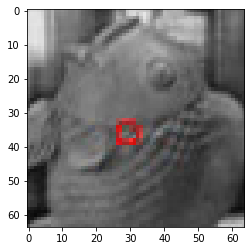

In [2]:
img = cv2.imread('fish.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Фильтр - сама картинка

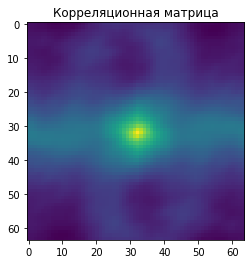

In [3]:
img_fft = np.fft.fft2(img)
correl_fft = img_fft * np.conj(img_fft)
correl = np.fft.ifft2(correl_fft)
correl = np.fft.fftshift(correl)
correl_view = np.abs(correl)

plt.imshow(correl_view)
plt.title('Корреляционная матрица')
plt.show()

# Фильтр - предобработанная картинка

In [4]:
def preprocess(image):
    image = image.astype('float32')

    # Логарифм для увеличения чувствительности к тёмным оттенкам
    image = np.log(1 + image)

    # Нормализация до среднего арифметического 0 и нормы 1
    mu = np.mean(image)
    sigma = np.std(image - mu)
    image = (image - mu) / sigma

    def sin2dwin(z):
        """ Создаёт маску 'виньетки' для изображения """
        xaxis = np.arange(z.shape[0])
        yaxis = np.arange(z.shape[1])
        x, y = np.meshgrid(xaxis, yaxis)
        wx = np.pi / x.shape[0]
        wy = np.pi / x.shape[1]
        return np.sin(wx * x) * np.sin(wy * y)

    # Добавляем 'виньетку'
    window = sin2dwin(image)
    image *= window

    return image

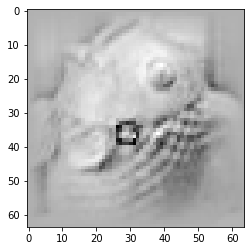

In [5]:
preprocessed_img = preprocess(img)

plt.imshow(preprocessed_img, cmap='gray')
plt.show()

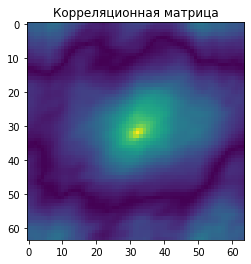

In [6]:
img_fft = np.fft.fft2(img)
preprocessed_img_fft = np.fft.fft2(preprocessed_img)
correl_fft = img_fft * np.conj(preprocessed_img_fft)
correl = np.fft.ifft2(correl_fft)
correl = np.fft.fftshift(correl)
correl_view = np.abs(correl)

plt.imshow(correl_view)
plt.title('Корреляционная матрица')
plt.show()

# Фильтр - фильтр

In [7]:
def get_desired_correl(image_resolution, sigma=2.0):
    """ Генерирует g с плотным (sigma=2.0) пиком гаусовой формы в центре """
    xaxis = np.arange(image_resolution[0])
    yaxis = np.arange(image_resolution[1])
    x, y = np.meshgrid(xaxis, yaxis)

    center = 0.5 * image_resolution
    norm1 = 1 / np.sqrt(2 * np.pi * sigma)
    norm2 = 1 / (2 * sigma ** 2)
    desired_correl = norm1 * np.exp(-(np.square(x - center[0]) + np.square(y - center[1])) * norm2)

    return desired_correl

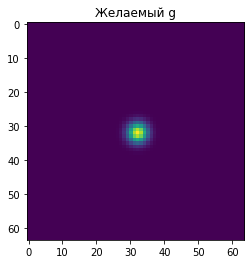

In [8]:
img_resolution = np.array(img.shape)
desired_output = get_desired_correl(img_resolution)

plt.imshow(desired_output)
plt.title('Желаемый g')
plt.show()

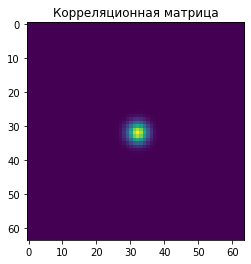

In [9]:
desired_output_fft = np.fft.fft2(desired_output)
img_fft = np.fft.fft2(img)
filter_conj_fft = desired_output_fft / img_fft

output_fft = img_fft * filter_conj_fft
output = np.fft.ifft2(output_fft)
# output = np.fft.fftshift(output)
output_view = np.abs(output)

plt.imshow(output_view)
plt.title('Корреляционная матрица')
plt.show()

# Работа с видео

## Без предобработки

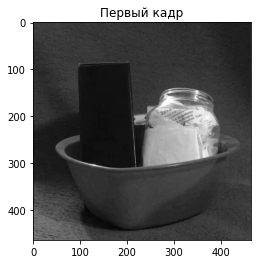

In [10]:
cap = cv2.VideoCapture('test video 464x464.mp4')

retval, first_frame = cap.read()
first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

plt.imshow(first_frame, cmap='gray')
plt.title('Первый кадр')
plt.show()

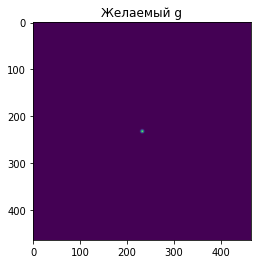

In [11]:
resolution = np.array(first_frame.shape)
desired_output = get_desired_correl(resolution)

plt.imshow(desired_output)
plt.title('Желаемый g')
plt.show()

In [12]:
# находим H*
desired_output_fft = np.fft.fft2(desired_output)
first_frame_fft = np.fft.fft2(first_frame)
filter_conj_fft = desired_output_fft / first_frame_fft

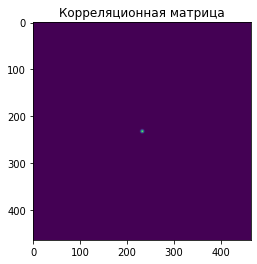

In [13]:
output_fft = first_frame_fft * filter_conj_fft
output = np.fft.ifft2(output_fft)
output_view = np.abs(output)

plt.imshow(output_view)
plt.title('Корреляционная матрица')
plt.show()

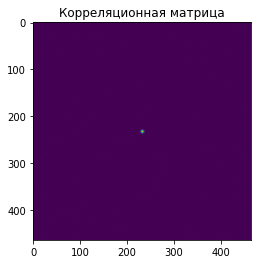

In [14]:
retval, second_frame = cap.read()
second_frame = cv2.cvtColor(second_frame, cv2.COLOR_BGR2GRAY)

second_frame_fft = np.fft.fft2(second_frame)

output_fft = second_frame_fft * filter_conj_fft
output = np.fft.ifft2(output_fft)
output_view = np.abs(output)

plt.imshow(output_view)
plt.title('Корреляционная матрица')
plt.show()

In [15]:
def get_filter_conj(frame):
    resolution = np.array(frame.shape)
    desired_correl = get_desired_correl(resolution)  # получаем желаемую корреляцию
    desired_correl_fft = np.fft.fft2(desired_correl)
    frame_fft = np.fft.fft2(frame)
    filter_conj_fft = desired_correl_fft / frame_fft  # нашли комплексное сопряжение фильтра
    return filter_conj_fft

In [16]:
cap = cv2.VideoCapture('test video 464x464.mp4')  # создаём объект захвата видео
correlation_writer = cv2.VideoWriter(  # создаём объект записи видео
    filename='correlation_video.mp4',
    fourcc=cv2.VideoWriter_fourcc(*'MP4V'),
    fps=30,
    frameSize=(464, 464)
)
capture_writer = cv2.VideoWriter(  # создаём объект записи видео
    filename='capture_video.mp4',
    fourcc=cv2.VideoWriter_fourcc(*'MP4V'),
    fps=30,
    frameSize=(464, 464)
)

# получаем комплексное сопряжение фильтра для первого кадра
retval, frame = cap.read()  # читаем первый кадр
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # конвертируем в оттенки серого
SHAPE = gray_frame.shape
CENTER = [SHAPE[0] // 2, SHAPE[1] // 2]  # [232, 232]
position = CENTER.copy()
filter_conj_fft = get_filter_conj(gray_frame)  # вычисляем комплексное сопряжение фильтра

cap = cv2.VideoCapture('test video 464x464.mp4')  # создаём объект захвата видео
shift = [0, 0]
shifts = []
while True:
    retval, frame = cap.read()
    if retval:
        # читаем кадр
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # вычисляем FFT кадра
        frame_fft = np.fft.fft2(gray_frame)
        # находим корреляционную матрицу в FFT области
        correl_fft = frame_fft * filter_conj_fft
        # находим корреляционную матрицу с помощью IFFT
        correl = np.fft.ifft2(correl_fft)
        # находим абсолютные значения для отрисовки матрицы
        correl_view = 255 * np.abs(correl)
        correl_view = correl_view.astype('uint8')
        
        # преобразуем в RGB
        correl_view_bgr = cv2.cvtColor(correl_view, cv2.COLOR_GRAY2BGR)
        # записываем картинку в видео
        correlation_writer.write(correl_view_bgr)
        
        peak = np.unravel_index(correl_view.argmax(), SHAPE)
        shift[0] = peak[0] - CENTER[0]
        shift[1] = peak[1] - CENTER[1]
        shifts.append(shift)
        
        position[0] += shift[1]
        position[1] += shift[0]
        cv2.circle(frame, center=position, radius=10, color=(0, 0, 255))
        capture_writer.write(frame)

        filter_conj_fft = get_filter_conj(gray_frame)
    else:
        correlation_writer.release()
        capture_writer.release()
        break

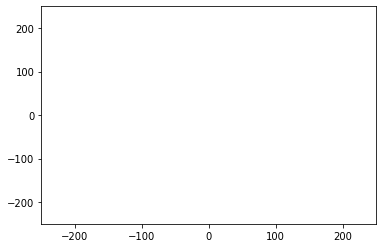

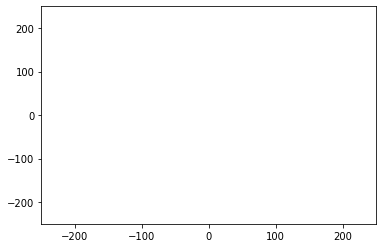

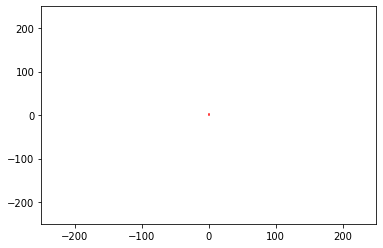

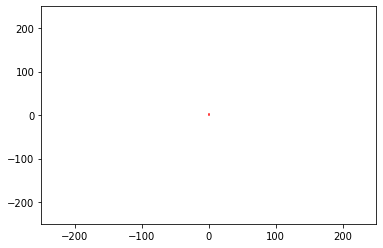

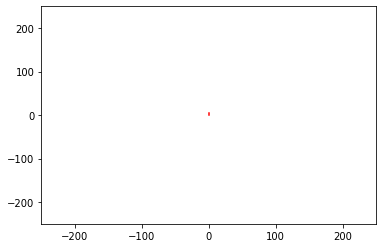

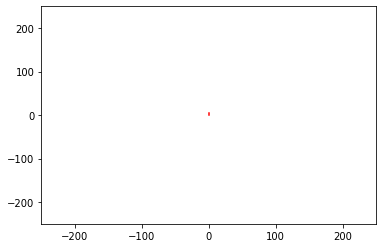

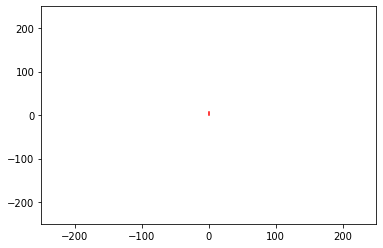

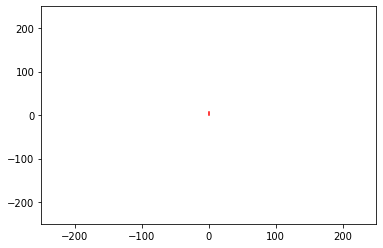

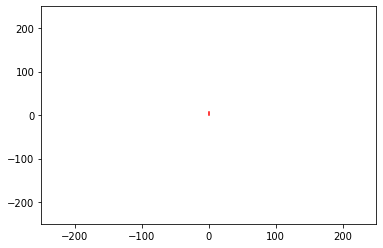

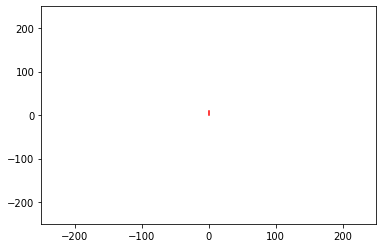

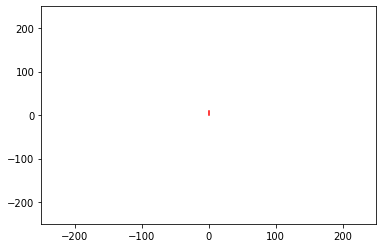

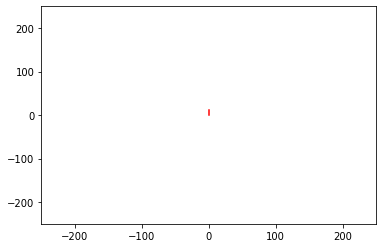

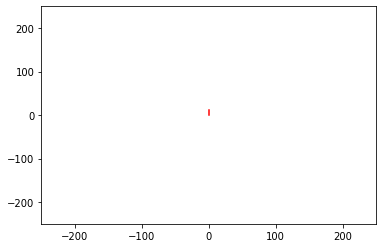

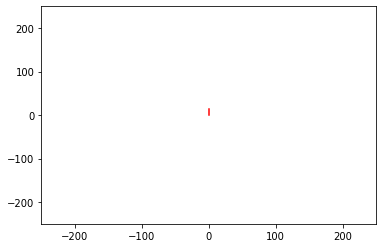

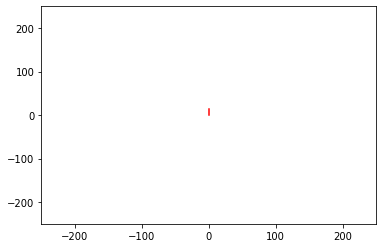

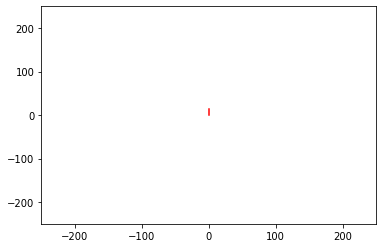

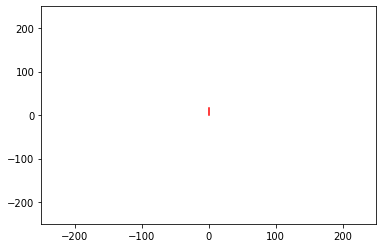

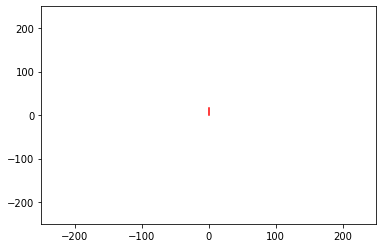

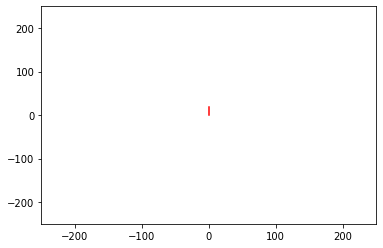

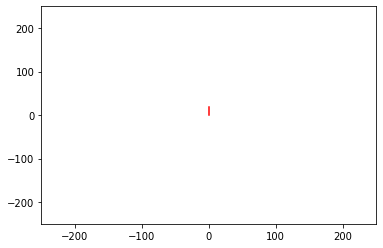

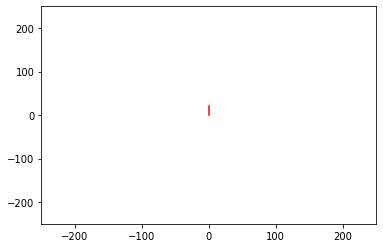

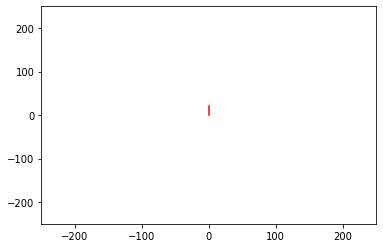

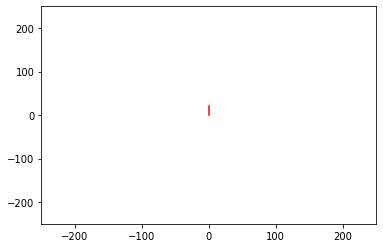

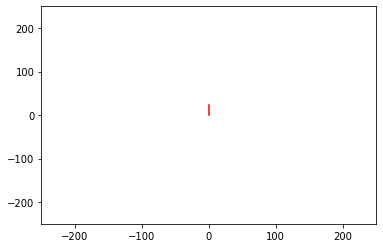

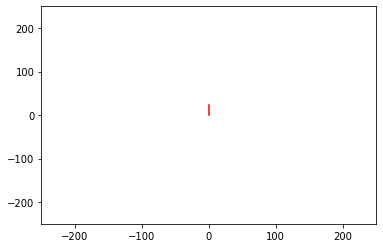

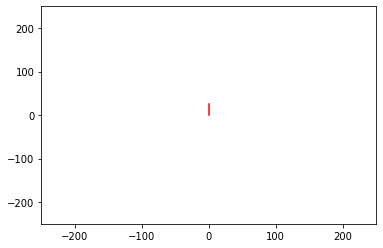

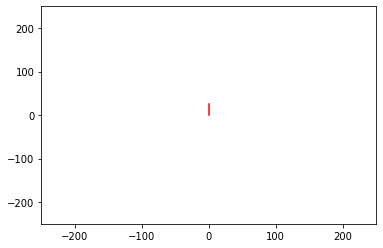

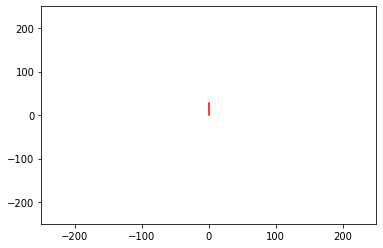

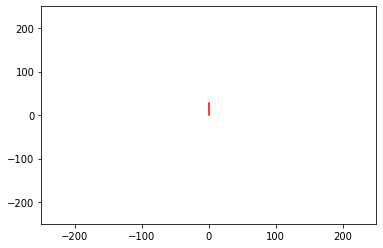

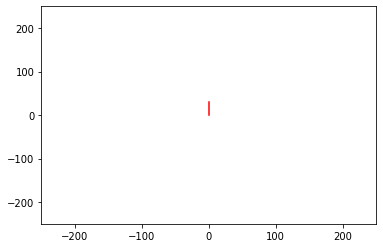

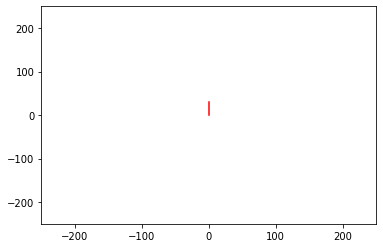

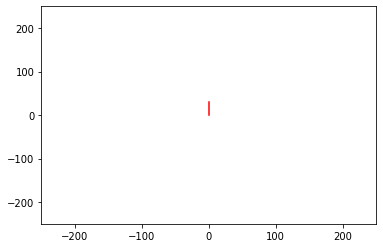

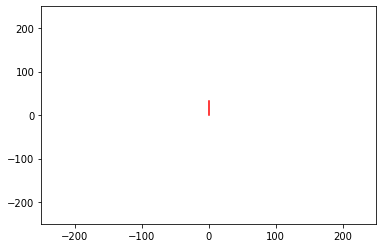

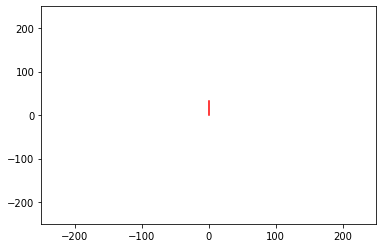

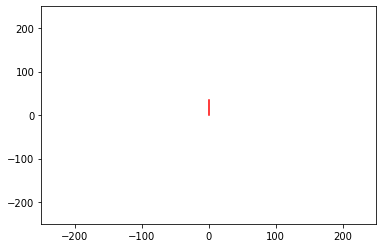

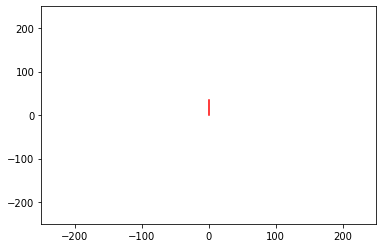

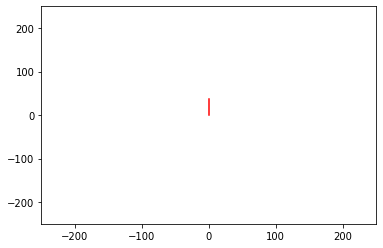

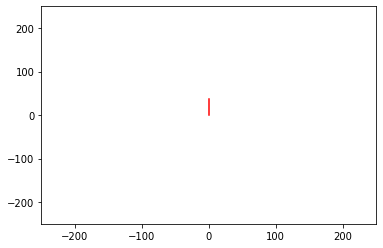

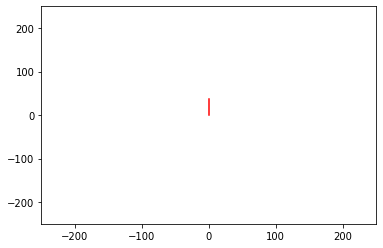

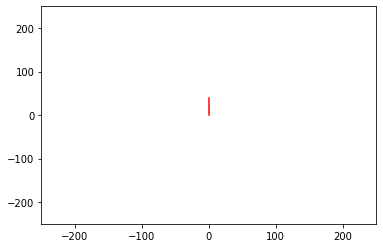

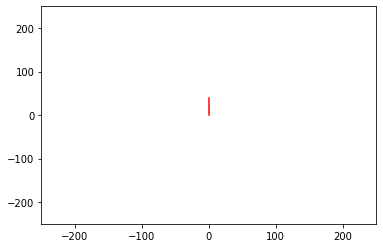

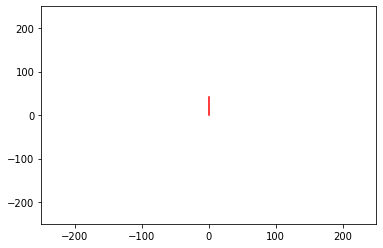

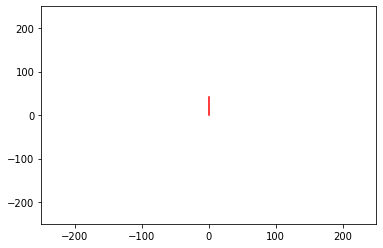

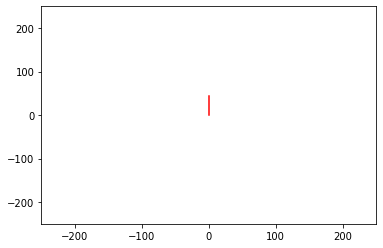

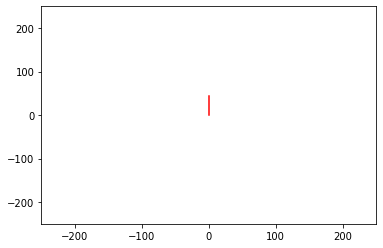

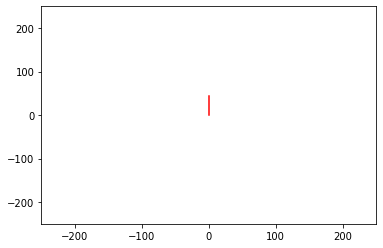

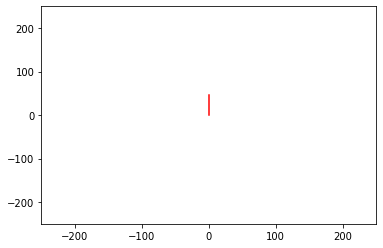

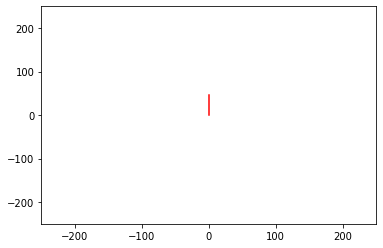

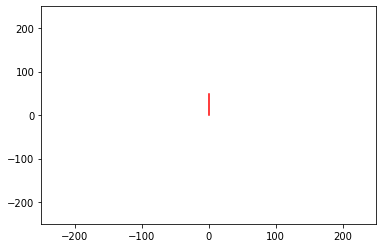

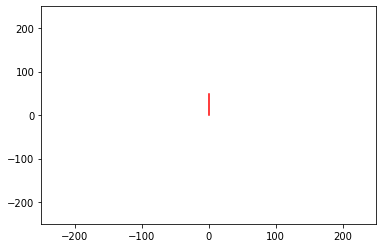

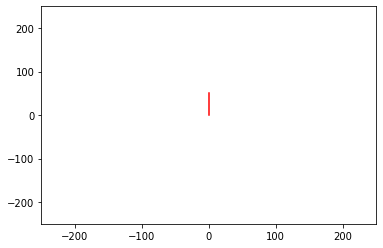

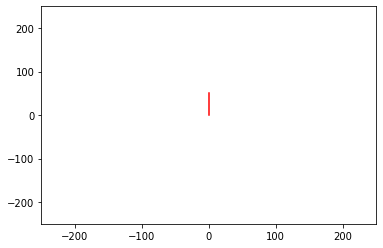

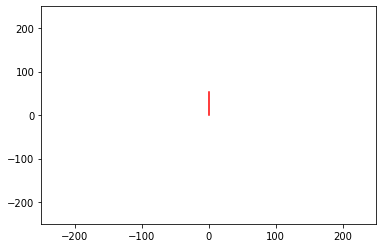

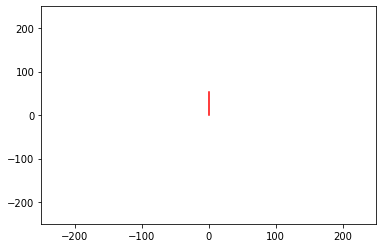

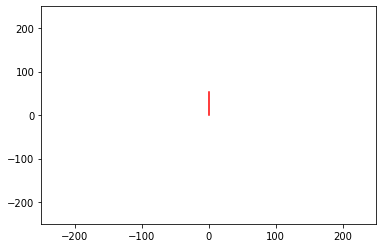

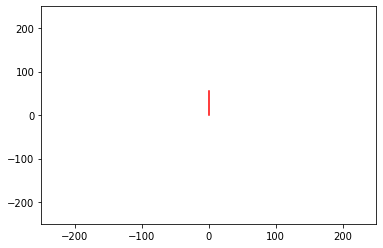

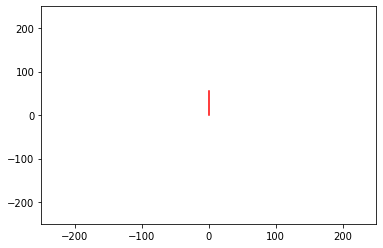

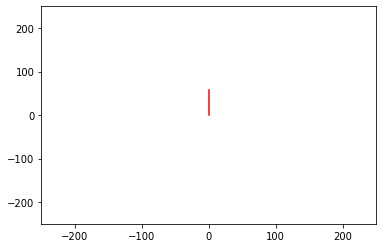

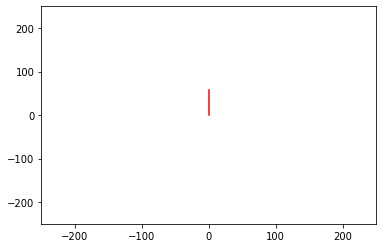

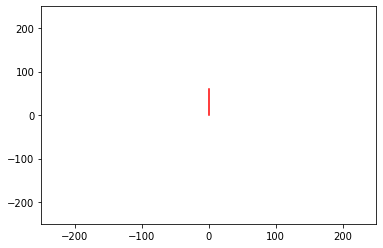

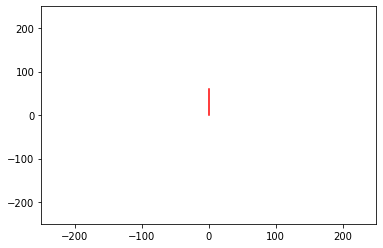

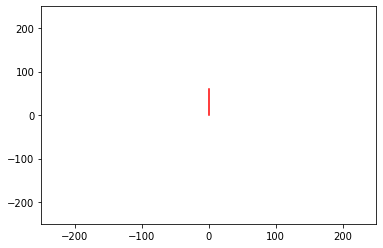

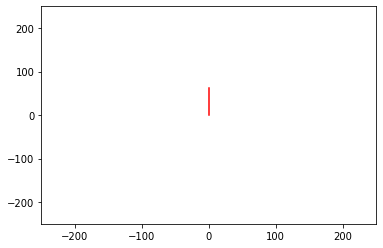

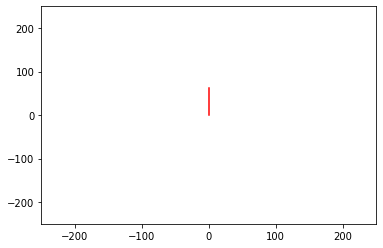

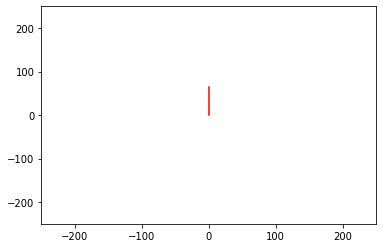

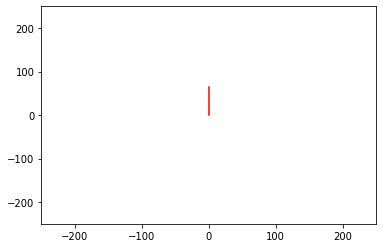

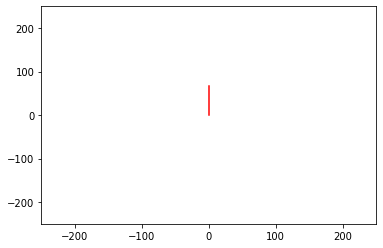

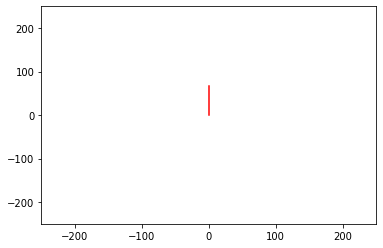

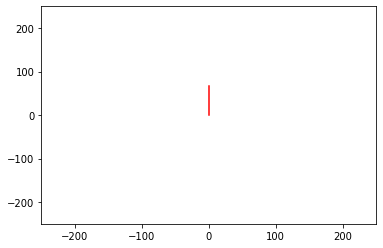

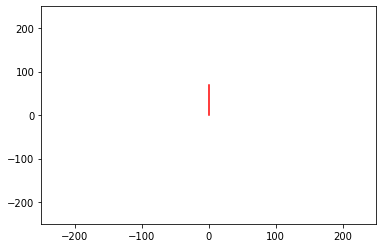

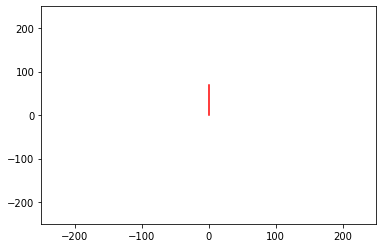

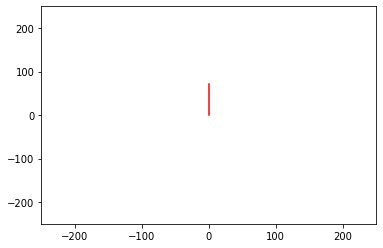

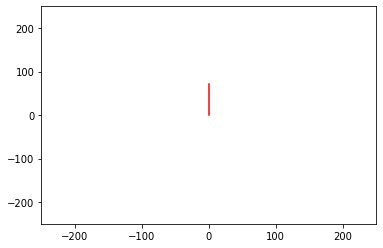

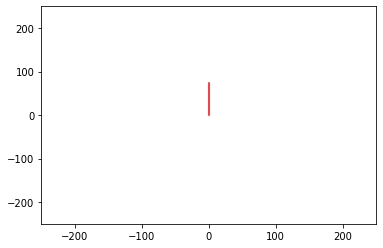

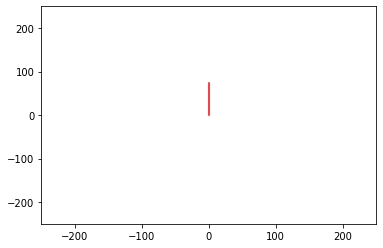

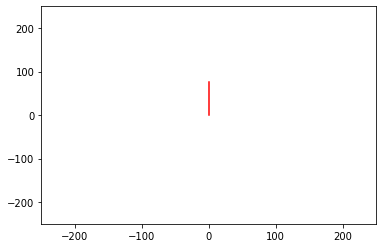

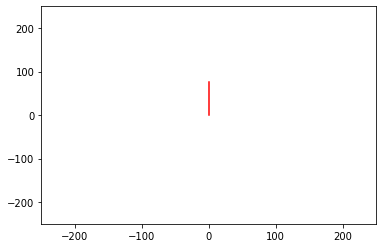

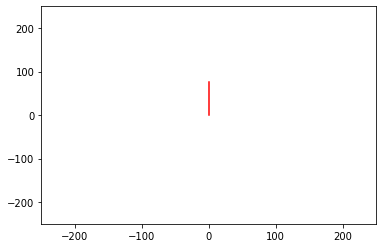

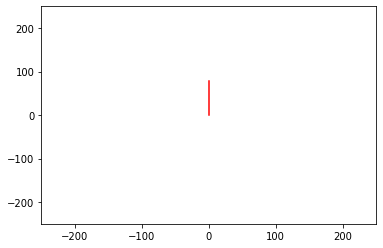

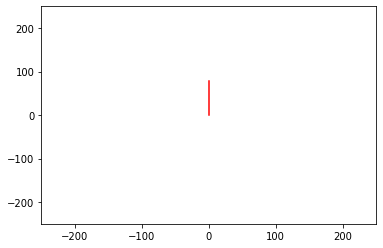

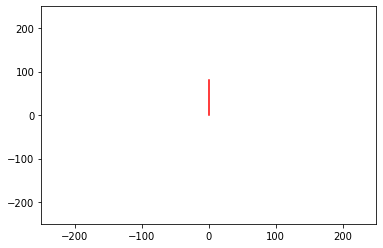

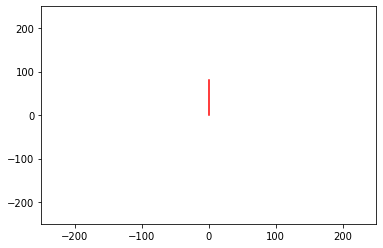

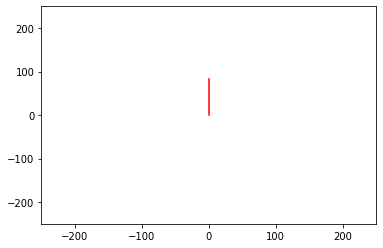

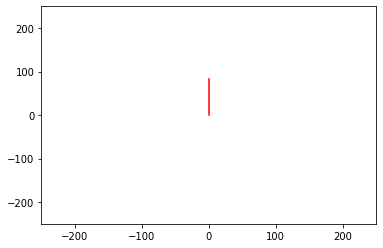

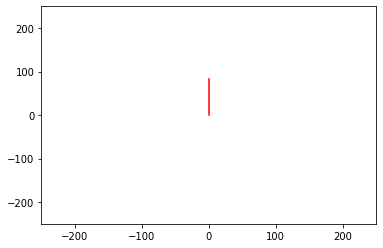

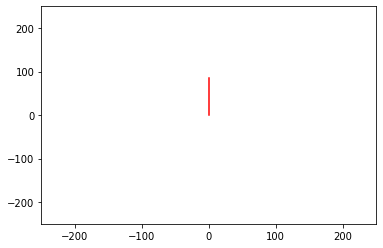

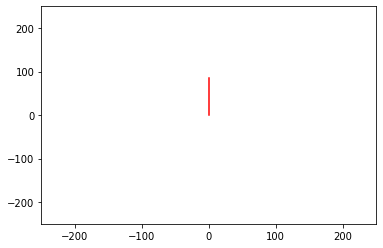

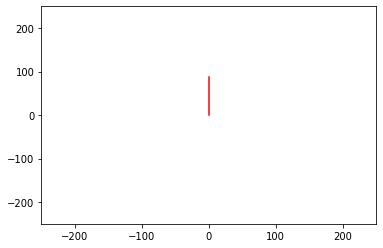

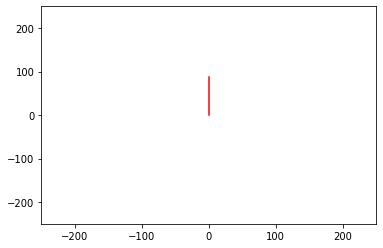

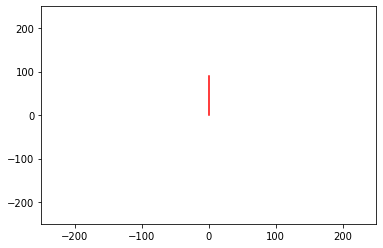

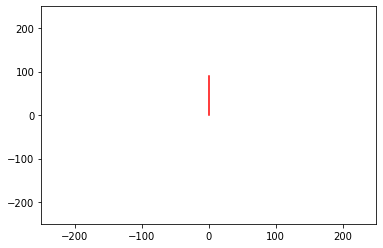

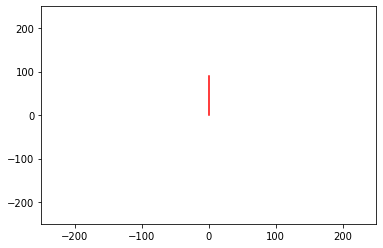

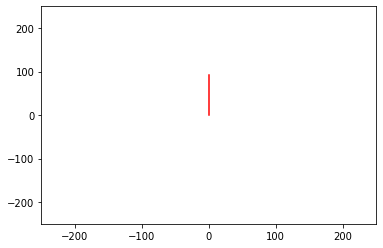

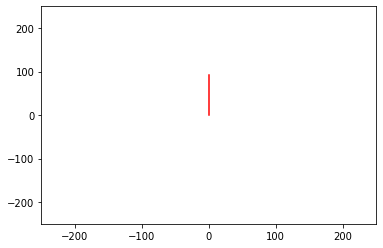

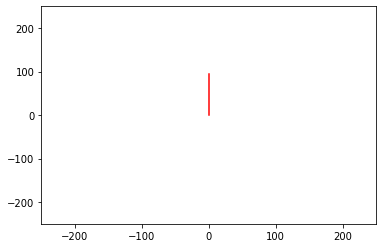

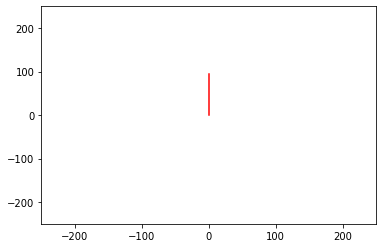

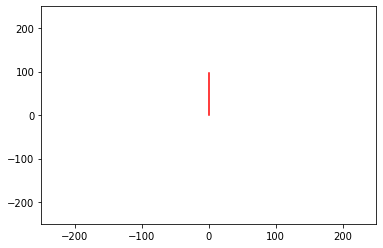

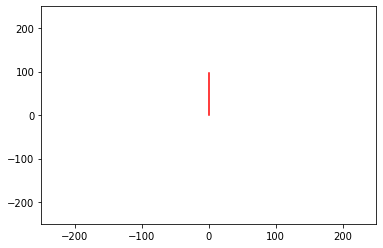

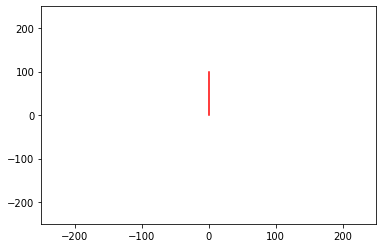

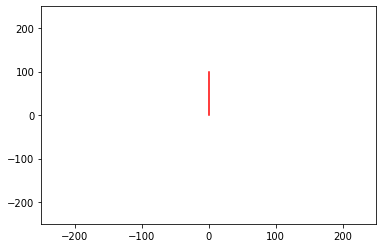

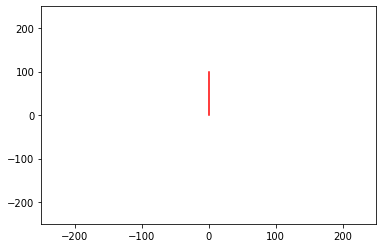

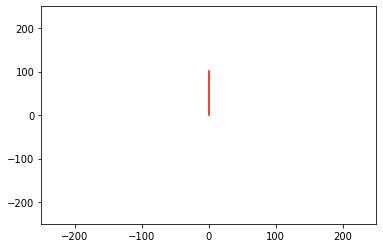

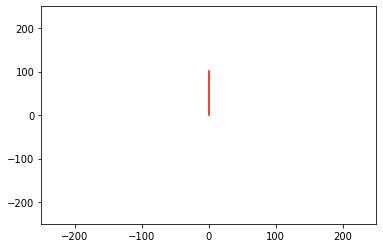

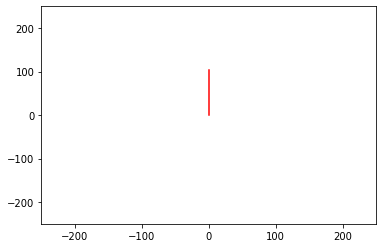

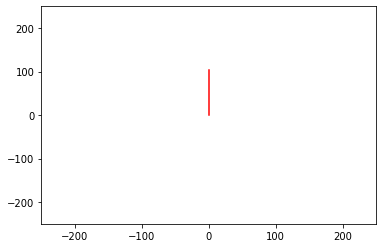

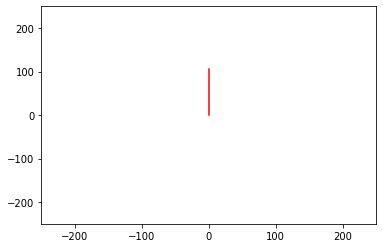

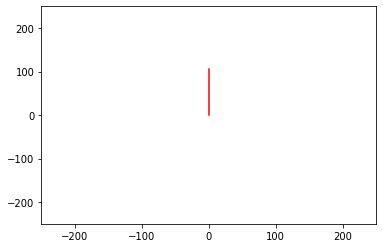

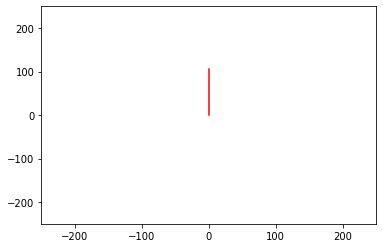

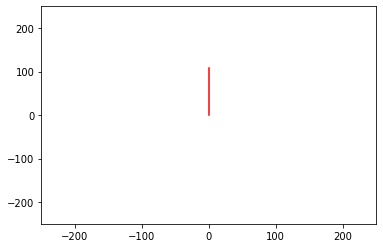

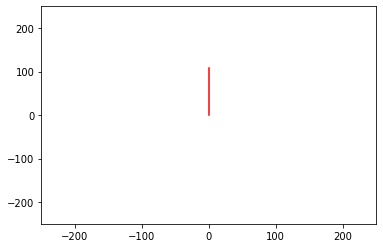

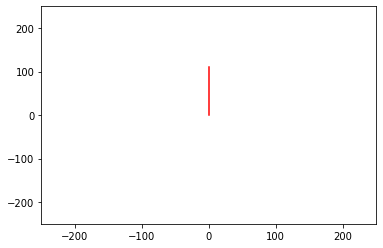

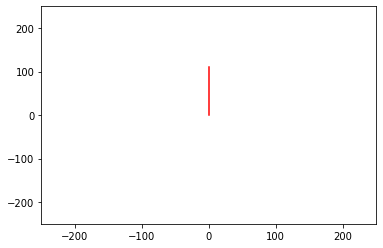

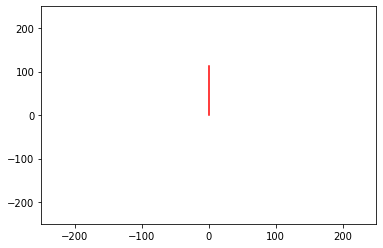

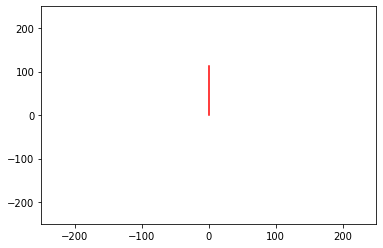

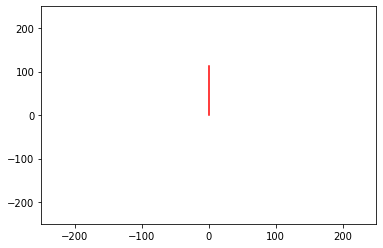

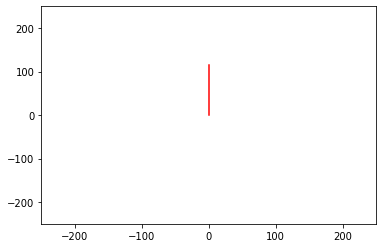

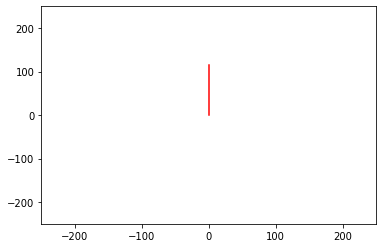

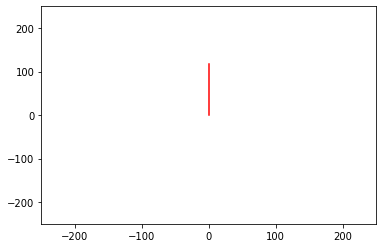

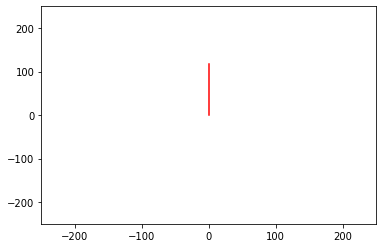

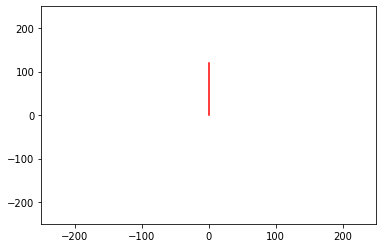

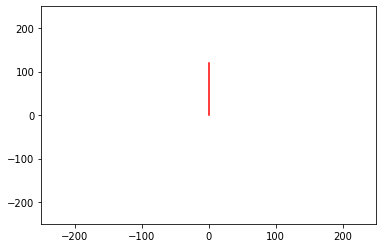

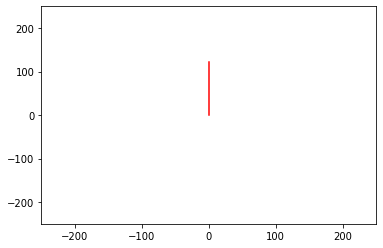

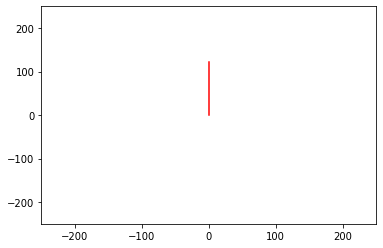

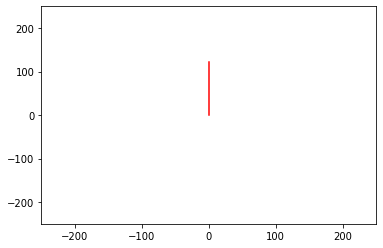

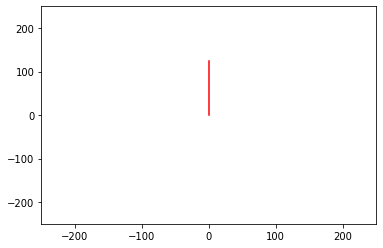

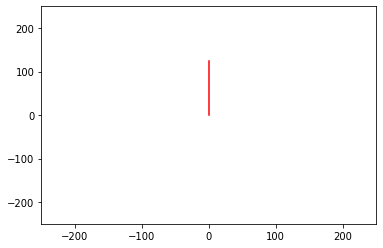

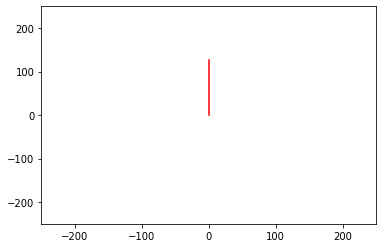

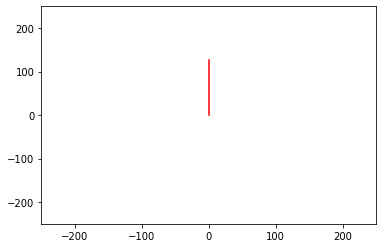

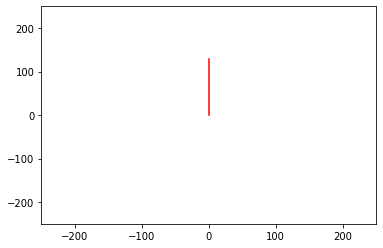

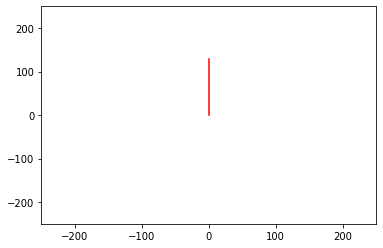

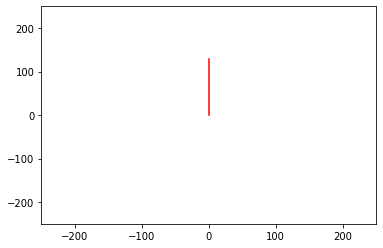

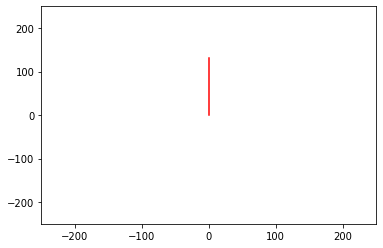

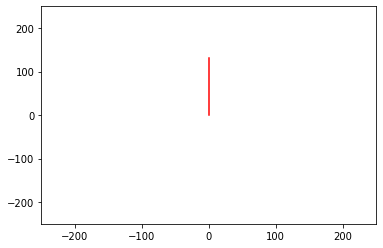

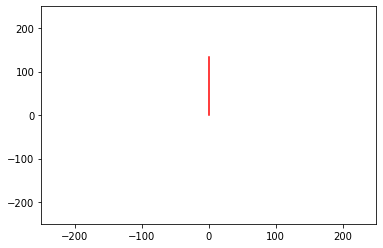

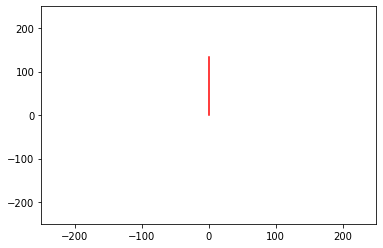

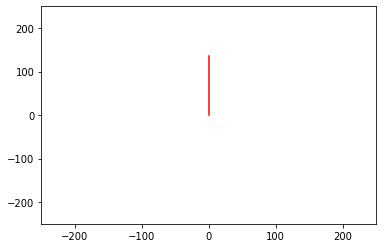

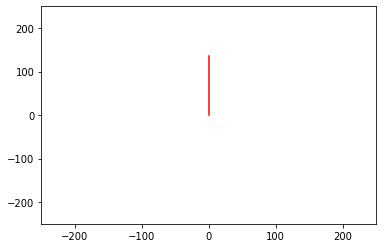

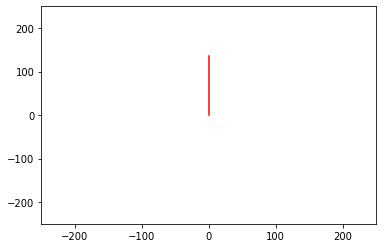

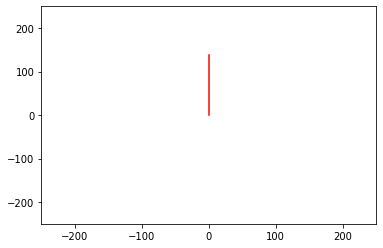

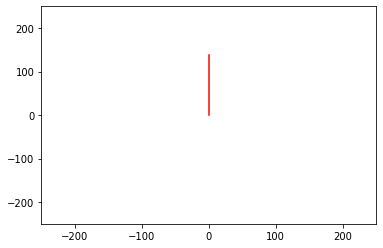

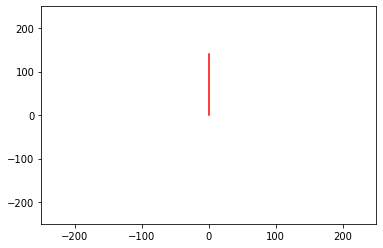

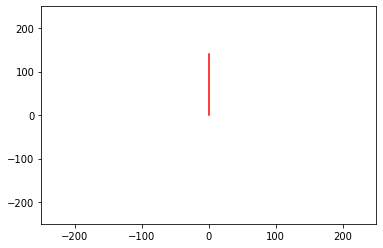

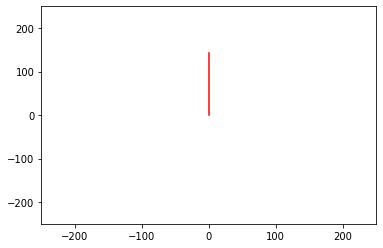

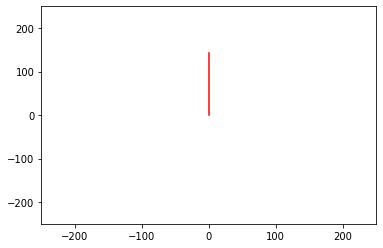

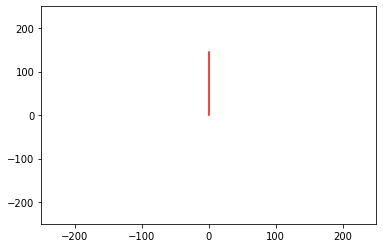

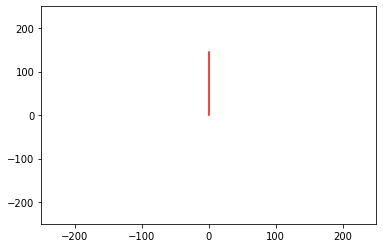

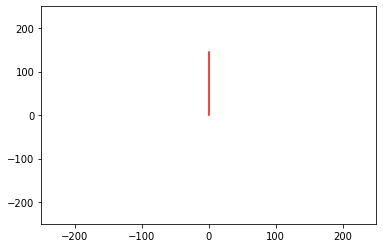

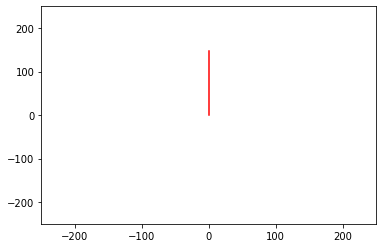

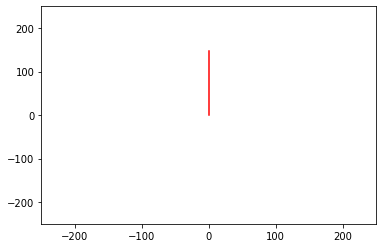

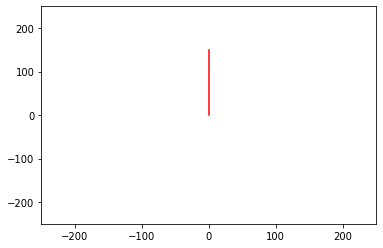

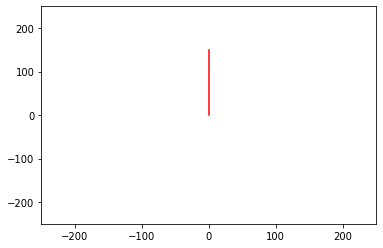

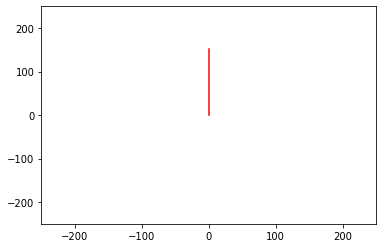

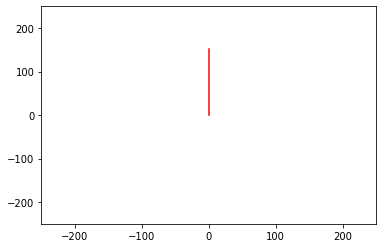

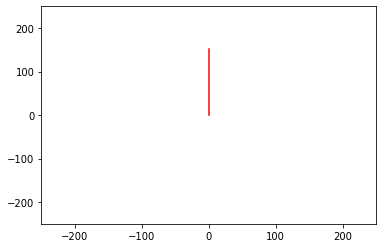

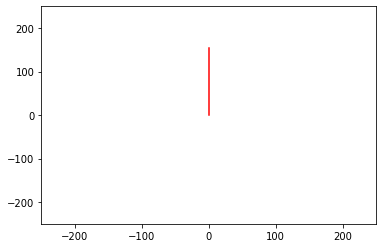

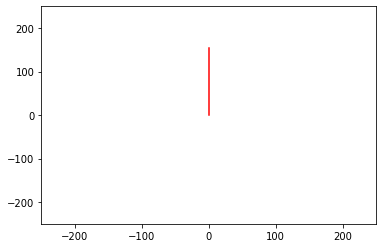

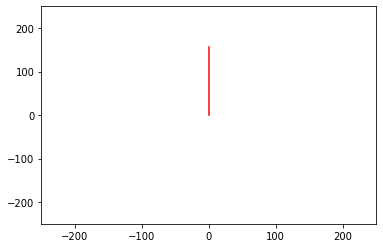

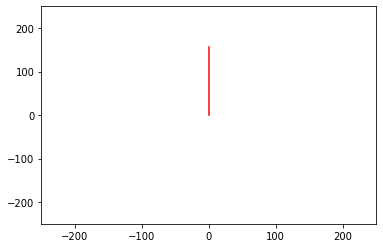

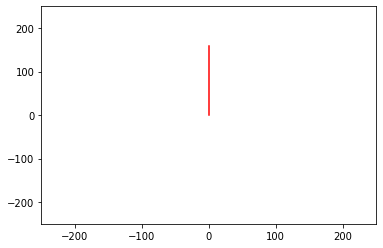

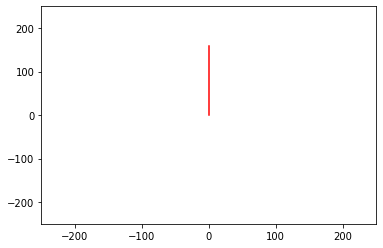

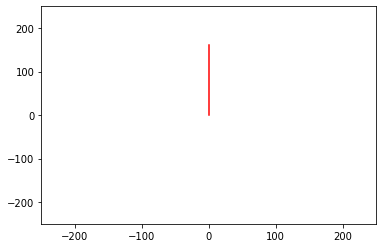

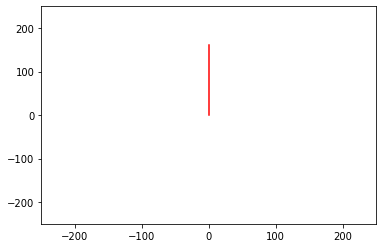

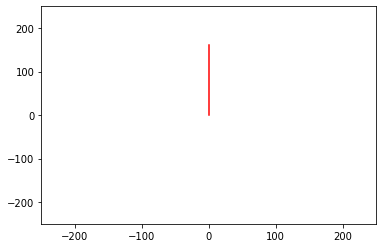

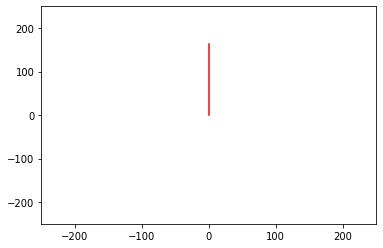

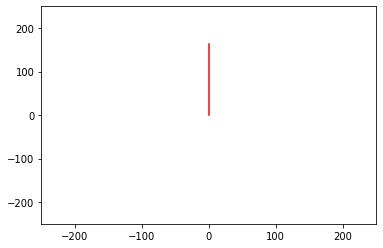

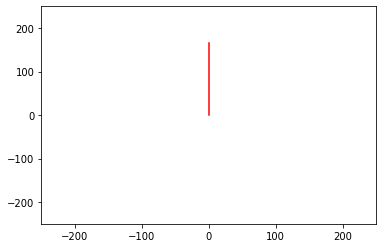

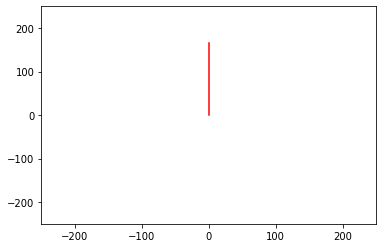

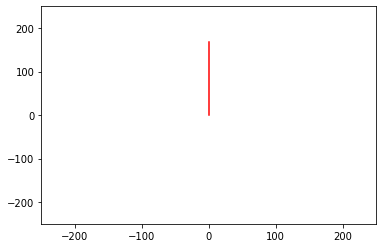

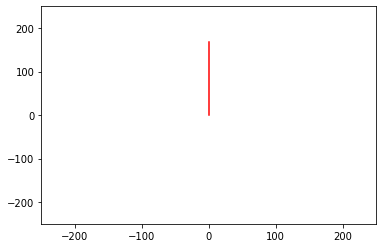

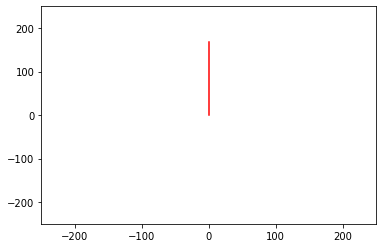

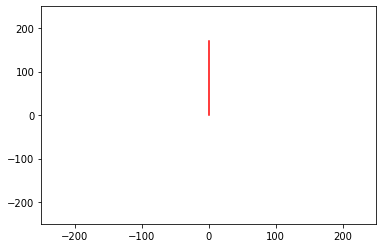

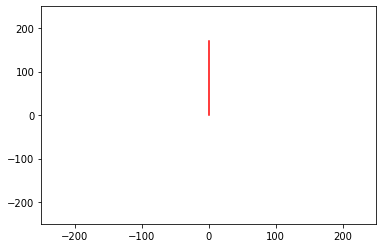

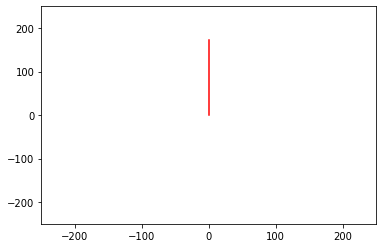

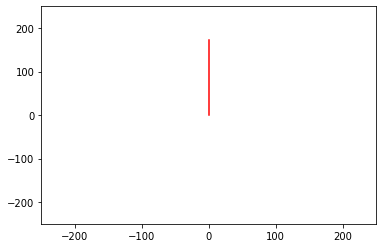

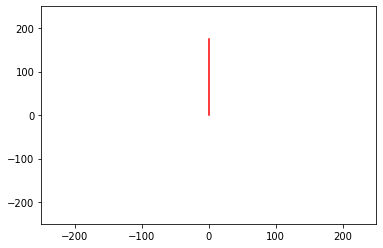

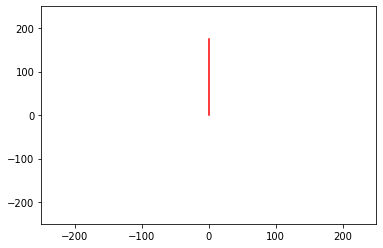

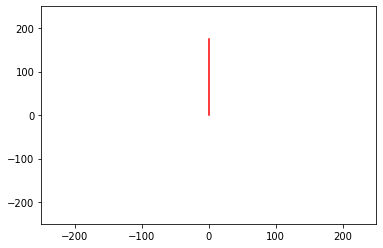

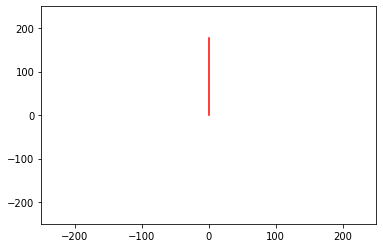

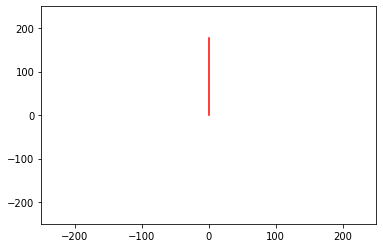

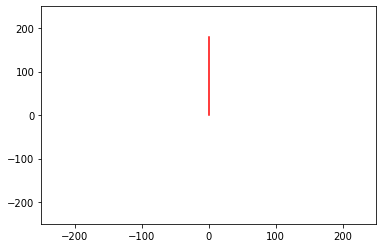

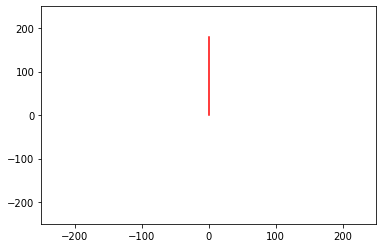

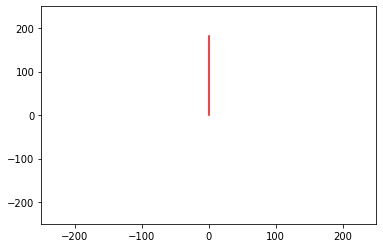

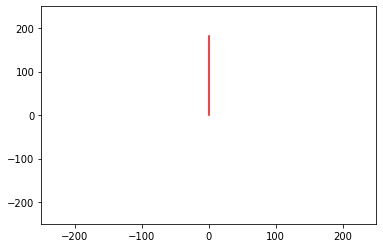

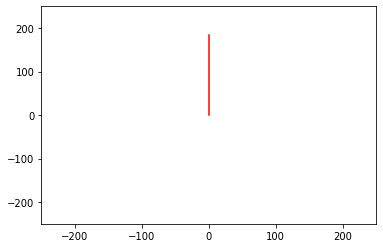

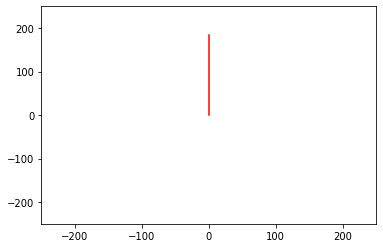

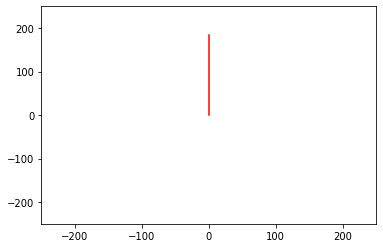

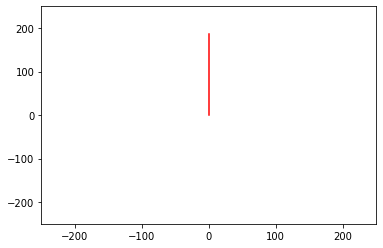

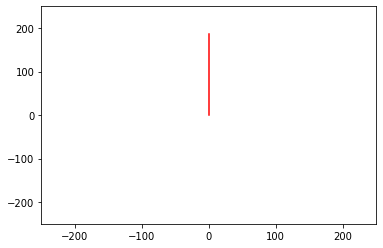

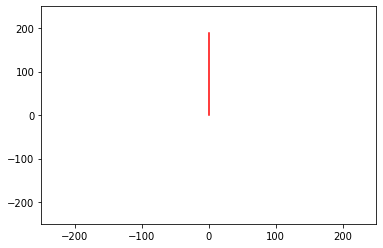

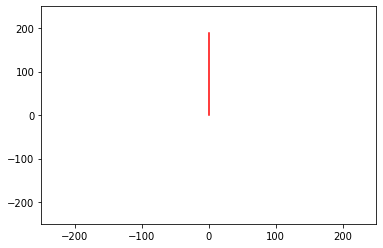

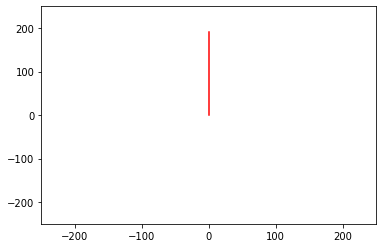

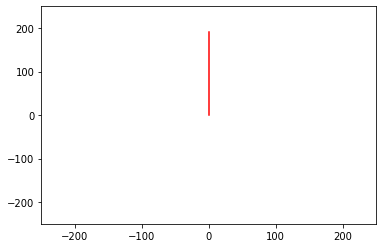

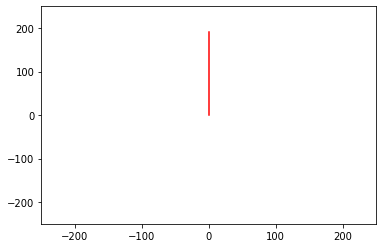

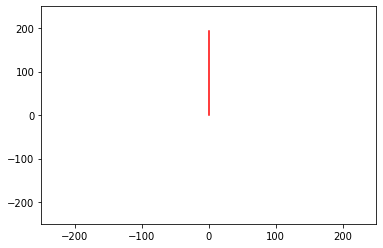

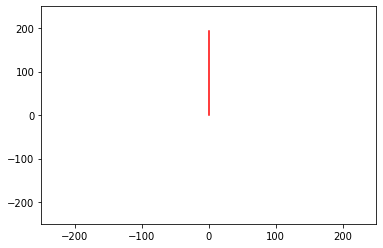

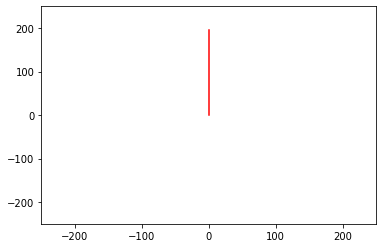

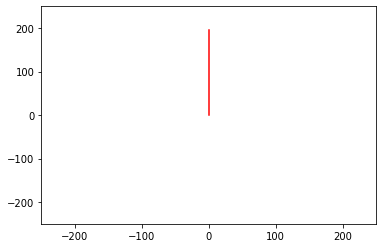

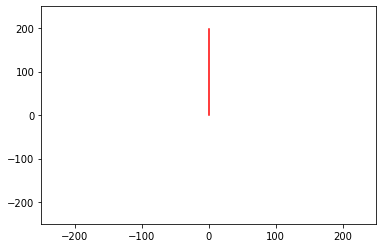

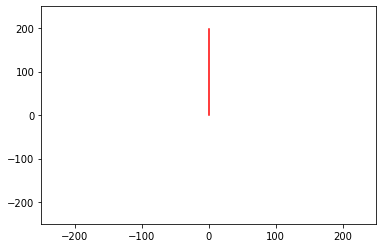

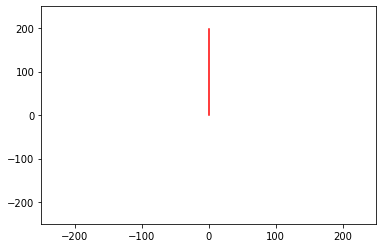

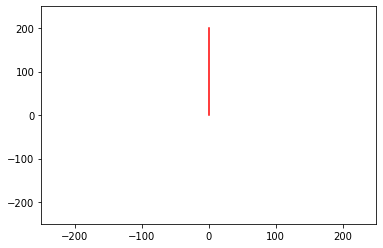

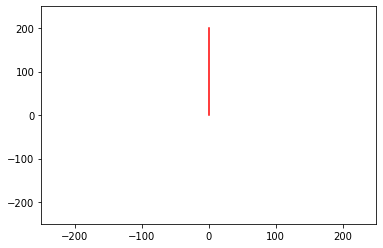

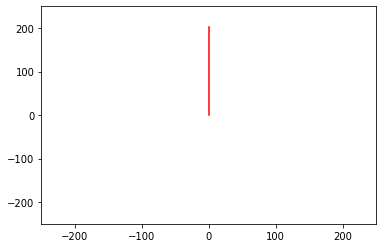

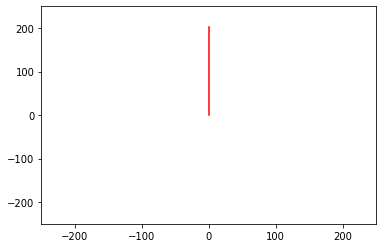

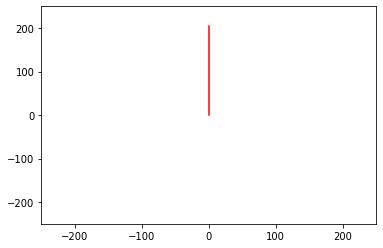

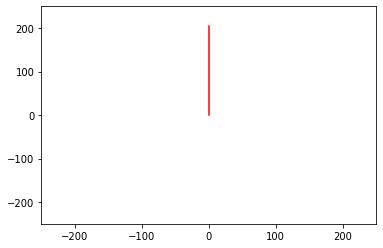

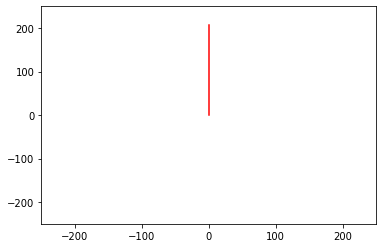

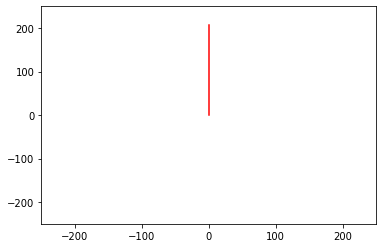

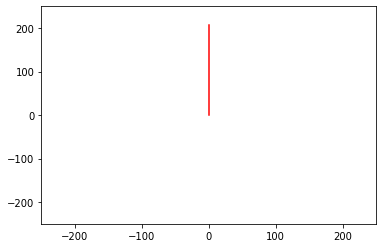

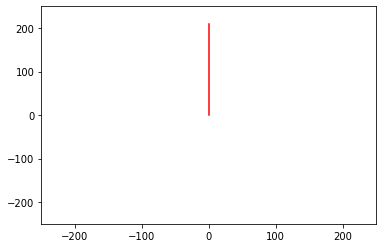

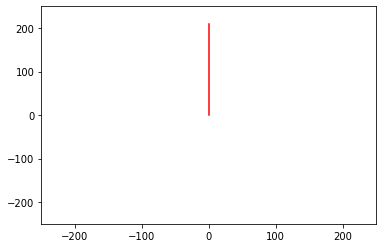

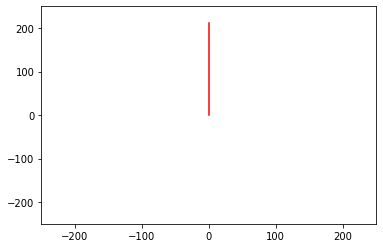

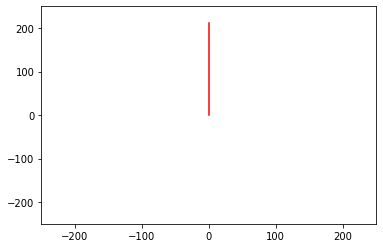

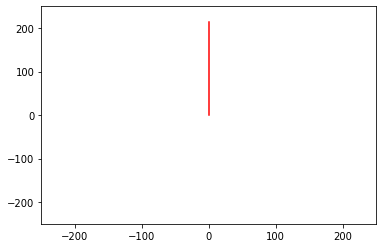

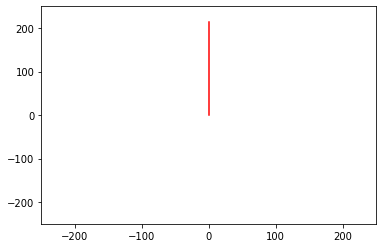

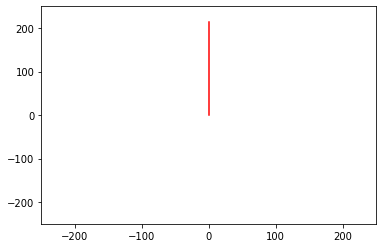

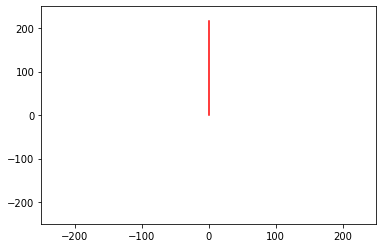

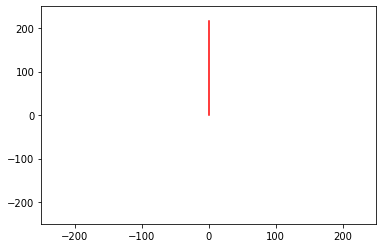

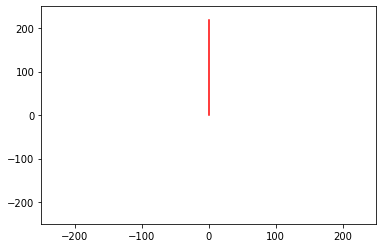

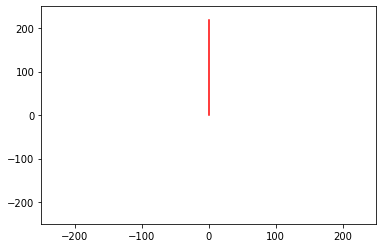

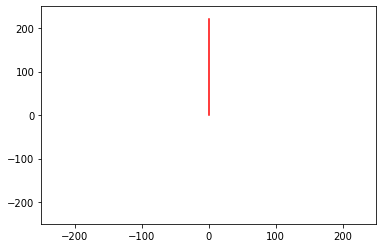

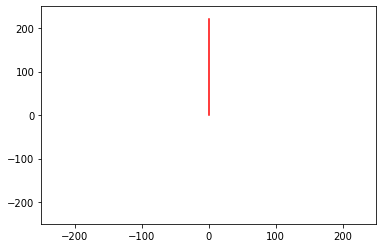

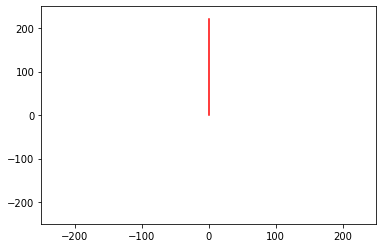

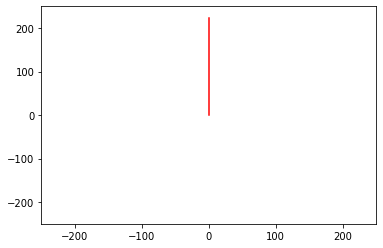

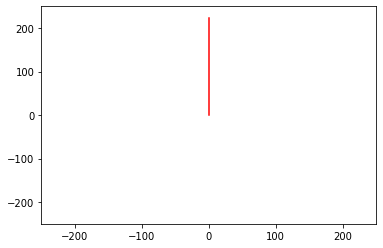

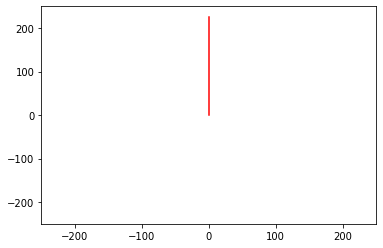

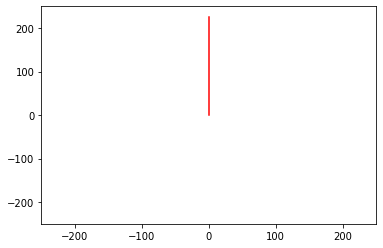

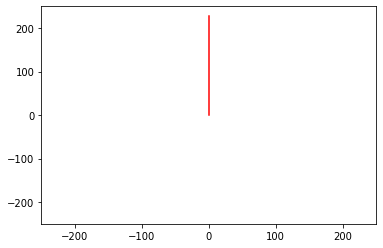

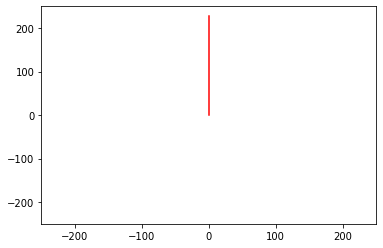

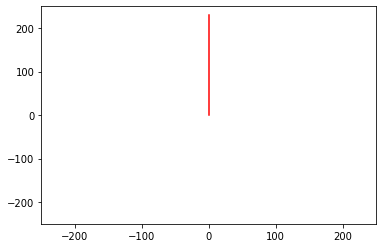

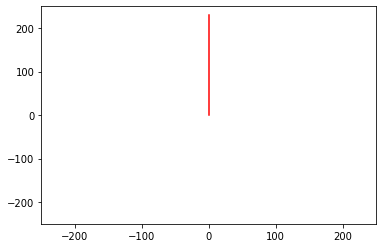

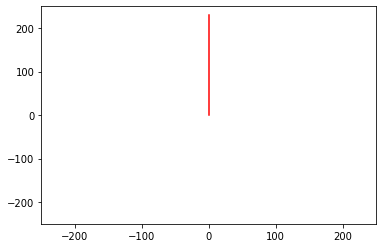

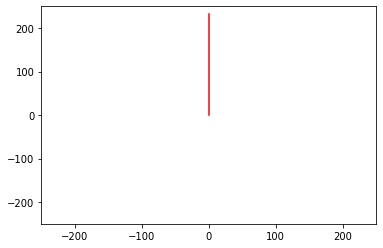

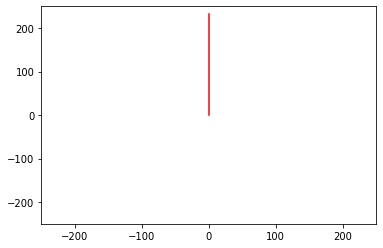

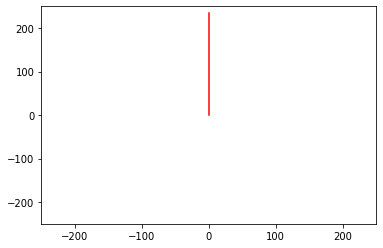

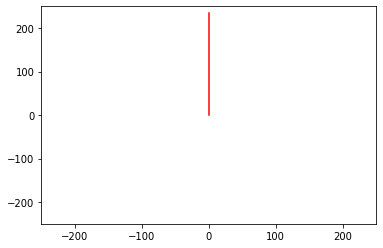

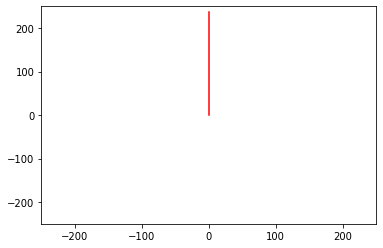

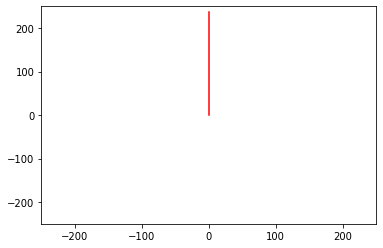

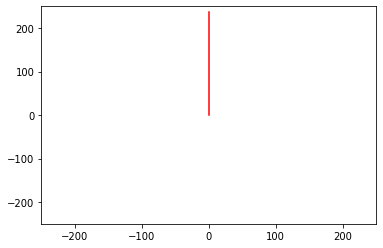

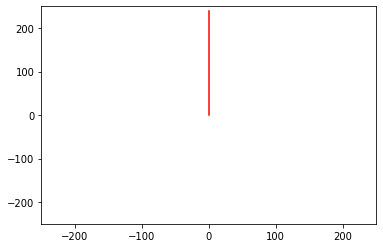

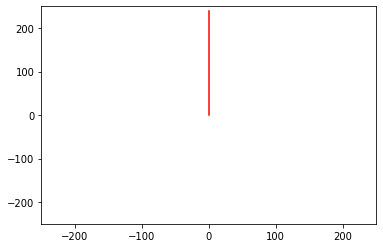

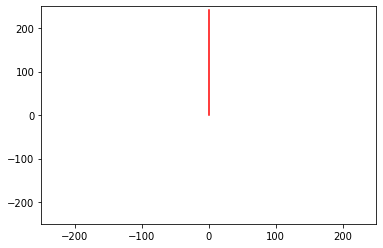

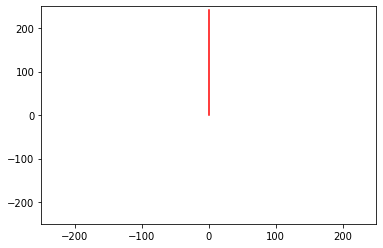

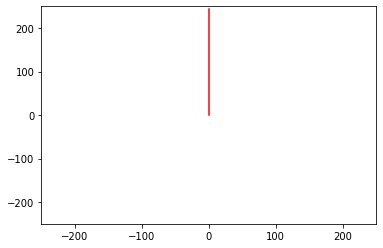

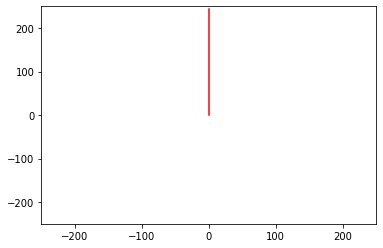

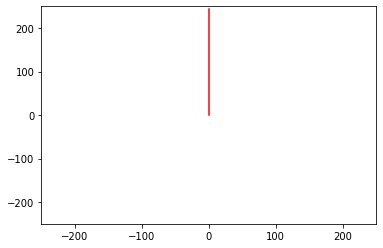

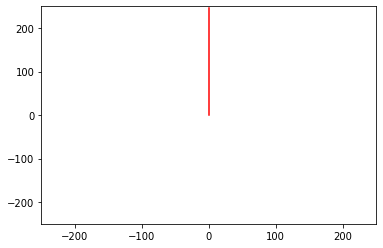

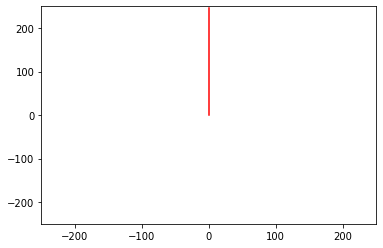

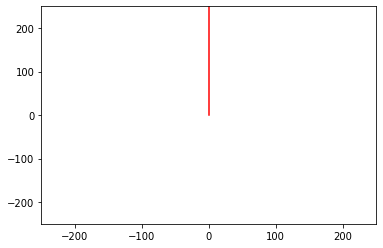

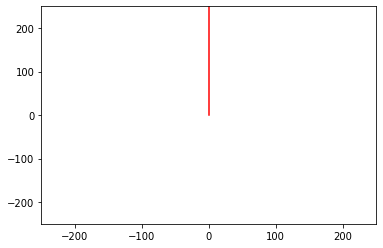

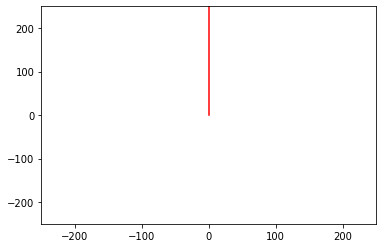

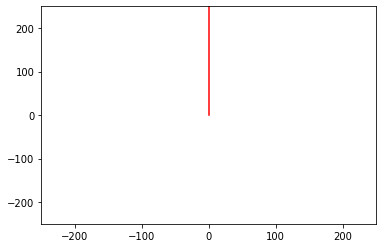

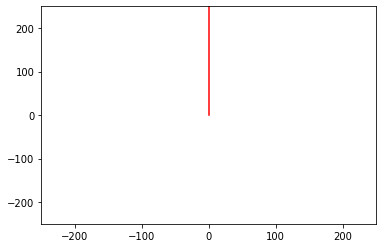

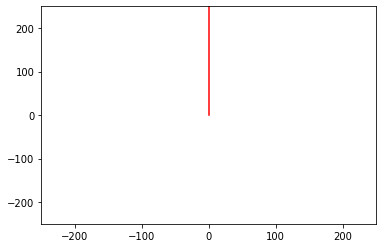

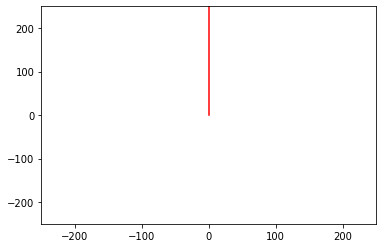

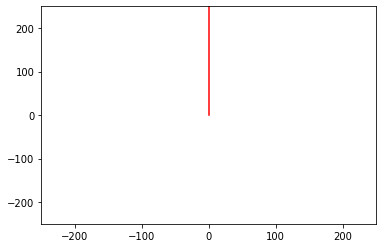

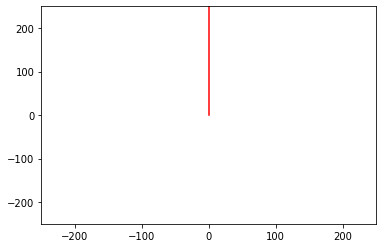

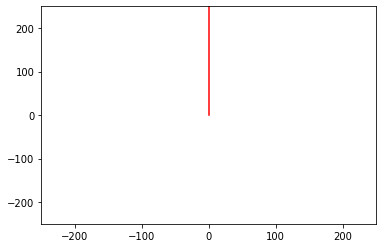

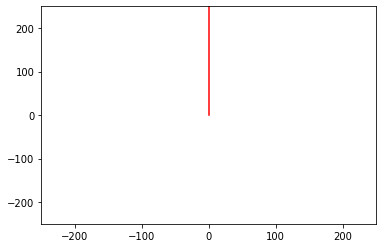

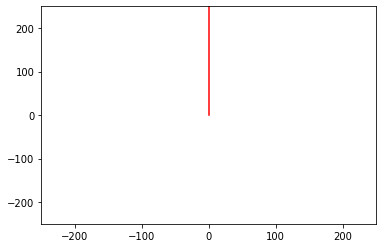

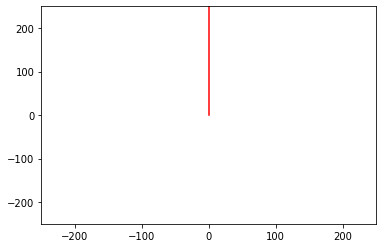

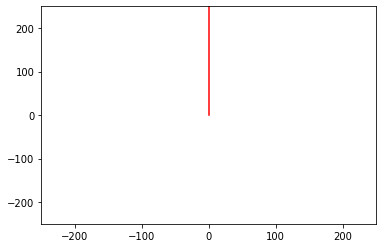

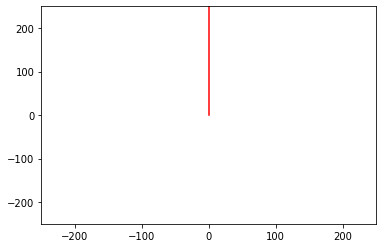

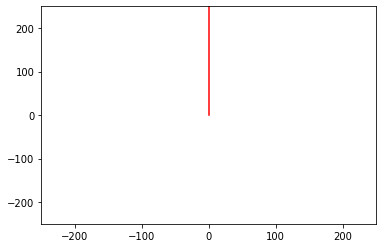

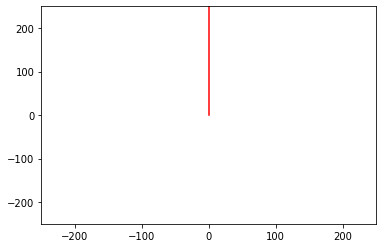

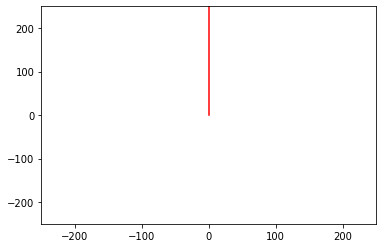

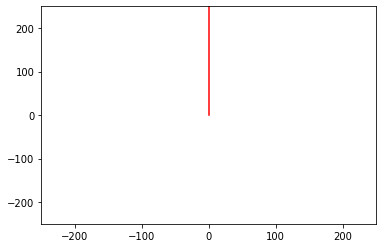

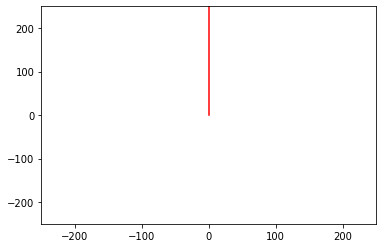

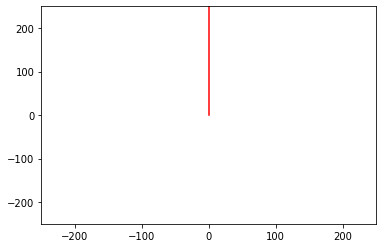

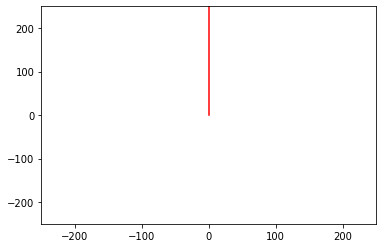

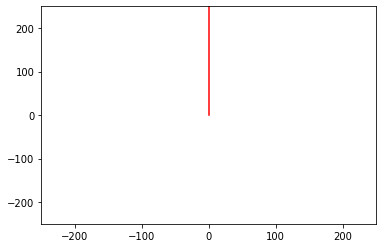

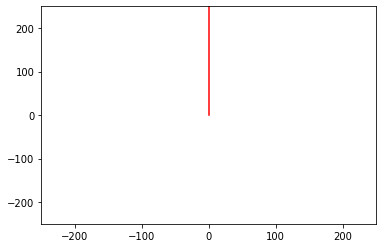

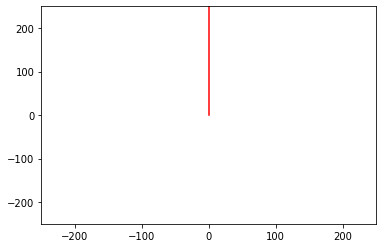

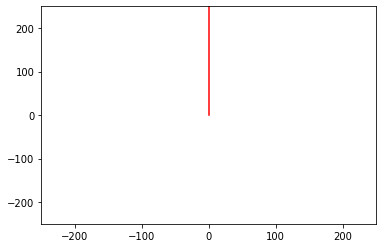

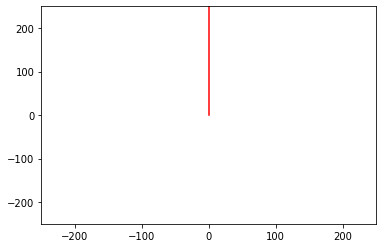

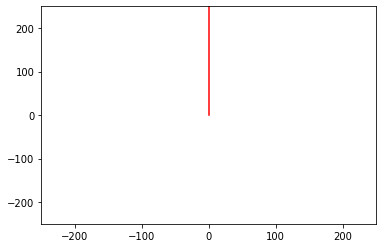

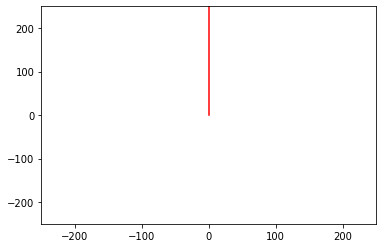

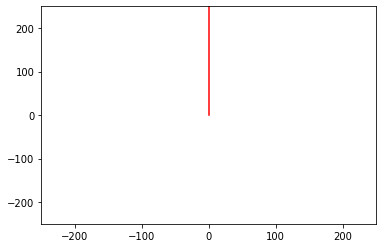

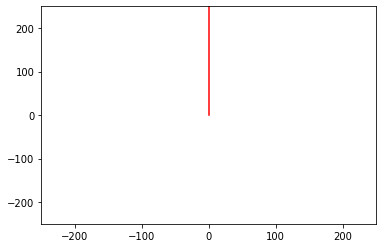

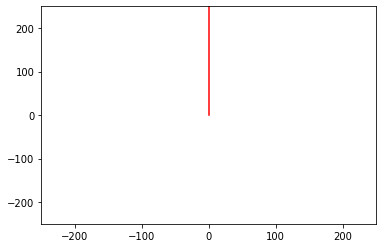

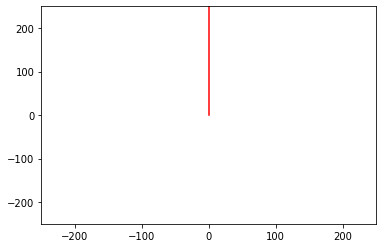

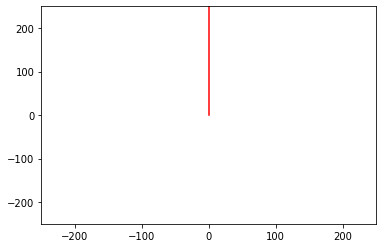

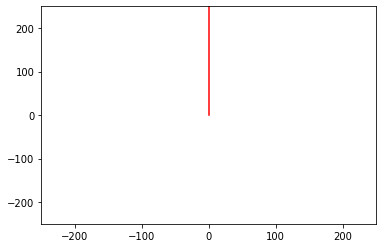

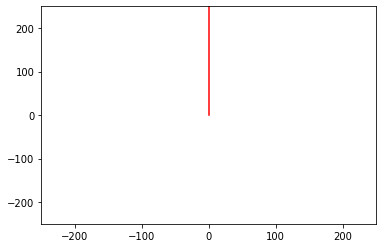

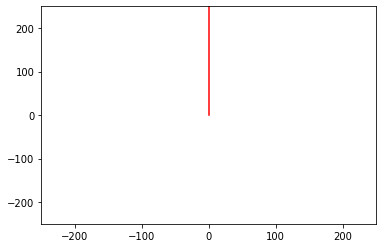

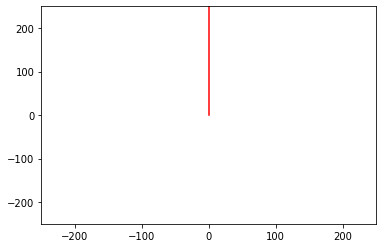

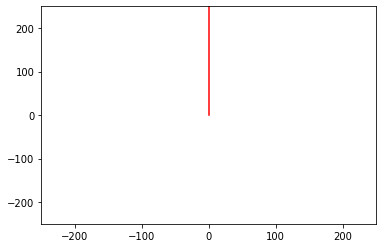

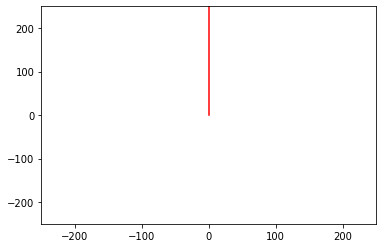

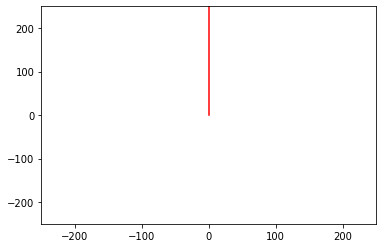

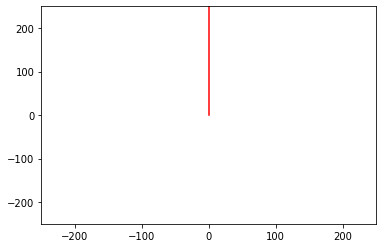

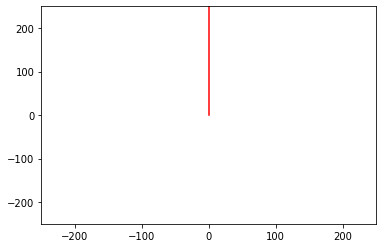

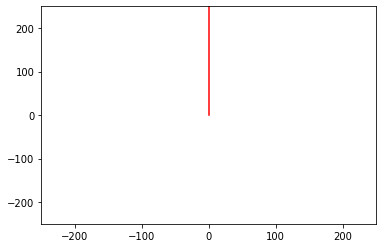

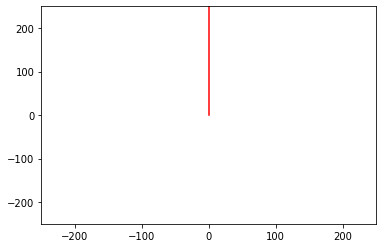

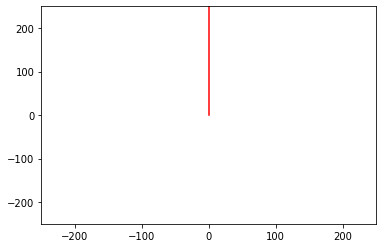

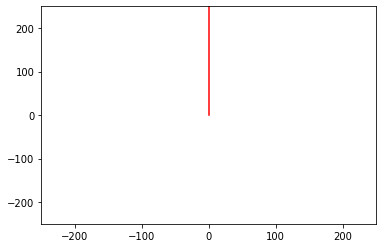

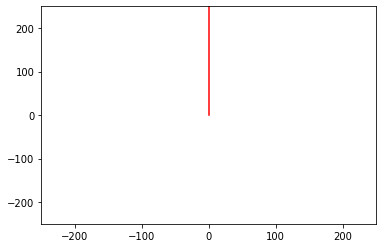

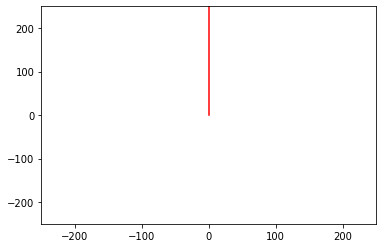

In [17]:
x = []
y = []
start = [0, 0]
for s in shifts:
    start[0] -= s[1]
    start[1] += s[0]
    x.append(start[0])
    y.append(start[1])

for i in range(len(x)):
    fig, ax = plt.subplots()
    ax.set_xlim([-250, 250])
    ax.set_ylim([-250, 250])
    ax.plot(x[0:i], y[0:i], color='red')
    plt.show()
    file_path = os.path.join('track', '{}.png'.format(i))
    fig.savefig(file_path)

In [18]:
track_video = cv2.VideoWriter(
    filename='track_video.mp4',
    fourcc=cv2.VideoWriter_fourcc(*'MP4V'),
    fps=30,
    frameSize=(432, 288)
)
file_names = os.listdir('track')
file_names.sort(key=lambda x: int(x[0:len(x) - 4]))
for file_name in file_names:
    file_path = os.path.join('track', file_name)
    img = cv2.imread(file_path)
    track_video.write(img)
track_video.release()